{/* cspell:ignore DMRG textrm varepsilon vecs pqrs ijkl */}

# Improving energy estimation of a fermionic lattice model with SQD

*Usage estimate: 9 seconds on IBM Aachen (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

In this tutorial, we show how to use sample-based quantum diagonalization (SQD) to estimate the ground state energy of a fermionic lattice model. Specifically, we study the one-dimensional single-impurity Anderson model (SIAM), which is used to describe magnetic impurities embedded in metals.

This tutorial follows a similar workflow to the related tutorial [*Improving energy estimation of a chemistry Hamiltonian with SQD*](https://learning.quantum.ibm.com/tutorial/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd). However, a key difference lies in how the quantum circuits are built. Whereas the other tutorial uses a heuristic variational ansatz, this tutorial uses circuits that approximate time evolution by the Hamiltonian. The state vectors prepared by these circuits form the basis for a [Krylov subspace](https://en.wikipedia.org/wiki/Krylov_subspace), and as a result, the algorithm provably and efficiently converges to the ground state, under suitable assumptions. This tutorial is based on the work [Quantum-Centric Algorithm for Sample-Based Krylov Diagonalization](https://arxiv.org/abs/2501.09702), which can be referred to for more details.

### Single-impurity Anderson model (SIAM)

The one-dimensional SIAM Hamiltonian is a sum of three terms:

$$
H = H_{\textrm{imp}}+ H_\textrm{bath} + H_\textrm{hyb},
$$

where

$$
\begin{align*}
  H_\textrm{imp} &= \varepsilon \left( \hat{n}_{d\uparrow} + \hat{n}_{d\downarrow} \right) + U \hat{n}_{d\uparrow}\hat{n}_{d\downarrow}, \\
  H_\textrm{bath} &= -t \sum_{\substack{\mathbf{j} = 0\\ \sigma\in \{\uparrow, \downarrow\}}}^{L-1} \left(\hat{c}^\dagger_{\mathbf{j}, \sigma}\hat{c}_{\mathbf{j}+1, \sigma} + \hat{c}^\dagger_{\mathbf{j}+1, \sigma}\hat{c}_{\mathbf{j}, \sigma} \right), \\
  H_\textrm{hyb} &= V\sum_{\sigma \in \{\uparrow, \downarrow \}} \left(\hat{d}^\dagger_\sigma \hat{c}_{0, \sigma} + \hat{c}^\dagger_{0, \sigma} \hat{d}_{\sigma} \right).
\end{align*}
$$

Here, $c^\dagger_{\mathbf{j},\sigma}/c_{\mathbf{j},\sigma}$ are the fermionic creation/annihilation operators for the $\mathbf{j}^{\textrm{th}}$ bath site with spin $\sigma$, $\hat{d}^\dagger_{\sigma}/\hat{d}_{\sigma}$ are creation/annihilation operators for the impurity mode, and $\hat{n}_{d\sigma} = \hat{d}^\dagger_{\sigma} \hat{d}_{\sigma}$. $t$, $U$, and $V$ are real numbers describing the hopping, on-site, hybridization interactions, and $\varepsilon$ is a real number specifying the chemical potential.

Note that the Hamiltonian is a specific instance of the generic interaction-electron Hamiltonian,

$$
\begin{align*}
  H &= \sum_{\substack{p, q \\ \sigma}} h_{pq} \hat{a}^\dagger_{p\sigma} \hat{a}_{q\sigma}  +  \sum_{\substack{p, q, r, s \\ \sigma \tau}} \frac{h_{pqrs}}{2} \hat{a}^\dagger_{p\sigma} \hat{a}^\dagger_{q\tau} \hat{a}_{s\tau} \hat{a}_{r\sigma} \\
  &= H_1 + H_2,
\end{align*}
$$

where $H_1$ consists of one-body terms, which are quadratic in the fermionic creation and annihilation operators, and $H_2$ consists of two-body terms, which are quartic. For the SIAM,
$$
H_2 = U \hat{n}_{d\uparrow}\hat{n}_{d\downarrow}
$$

and $H_1$ contains the rest of the terms in the Hamiltonian. In order to represent the Hamiltonian programmatically, we store the matrix $h_{pq}$ and the tensor $h_{pqrs}$.

### Position and momentum bases

Due to the approximate translational symmetry in $H_\textrm{bath}$, we don't expect the ground state to be sparse in the position basis (the orbital basis in which the Hamiltonian is specified above). The performance of SQD is guaranteed only if the ground state is sparse, that is, it has significant weight on only a small number of computational basis states. To improve the sparsity of the ground state, we perform the simulation in the orbital basis in which $H_\textrm{bath}$ is diagonal. We call this basis the *momentum basis*. Because $H_\textrm{bath}$ is a quadratic fermionic Hamiltonian, it can be efficiently diagonalized by an orbital rotation.

### Approximate time evolution by the Hamiltonian

To approximate time evolution by the Hamiltonian, we use a second order Trotter-Suzuki decomposition,

$$
  e^{-i \Delta t H} \approx e^{-i\frac{\Delta t}{2} H_2} e^{-i\Delta t H_1} e^{-i\frac{\Delta t}{2} H_2}.
$$

Under the [Jordan-Wigner transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation), time evolution by $H_2$ amounts to a single [CPhase](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CPhaseGate) gate between the spin-up and spin-down orbitals at the impurity site. Because $H_1$ is a quadratic fermionic Hamiltonian, time evolution by $H_1$ amounts to an orbital rotation.

The Krylov basis states $\{ |\psi_k\rangle \}_{k=0}^{D-1}$, where $D$ is the dimension of the Krylov subspace, are formed by repeated application of a single Trotter step, so

$$
  |\psi_k\rangle \approx \left[e^{-i\frac{\Delta t}{2} H_2} e^{-i\Delta t H_1} e^{-i\frac{\Delta t}{2} H_2} \right]^k\ket{\psi_0}.
$$

## Step 1: Map problem to a quantum circuit

First, we generate the SIAM Hamiltonian in the position basis. The Hamiltonian is represented by the matrix $h_{pq}$ and the tensor $h_{pqrs}$. Then, we rotate it to the momentum basis. In the position basis, we place the impurity at the first site. However, when we rotate to the momentum basis, we move the impurity to a central site to facilitate interactions with other orbitals.

In [1]:
import numpy as np


def siam_hamiltonian(
    norb: int,
    hopping: float,
    onsite: float,
    hybridization: float,
    chemical_potential: float,
) -> tuple[np.ndarray, np.ndarray]:
    """Hamiltonian for the single-impurity Anderson model."""
    # Place the impurity on the first site
    impurity_orb = 0

    # One body matrix elements in the "position" basis
    h1e = np.zeros((norb, norb))
    np.fill_diagonal(h1e[:, 1:], -hopping)
    np.fill_diagonal(h1e[1:, :], -hopping)
    h1e[impurity_orb, impurity_orb + 1] = -hybridization
    h1e[impurity_orb + 1, impurity_orb] = -hybridization
    h1e[impurity_orb, impurity_orb] = chemical_potential

    # Two body matrix elements in the "position" basis
    h2e = np.zeros((norb, norb, norb, norb))
    h2e[impurity_orb, impurity_orb, impurity_orb, impurity_orb] = onsite

    return h1e, h2e


def momentum_basis(norb: int) -> np.ndarray:
    """Get the orbital rotation to change from the position to the momentum basis."""
    n_bath = norb - 1

    # Orbital rotation that diagonalizes the bath (non-interacting system)
    hopping_matrix = np.zeros((n_bath, n_bath))
    np.fill_diagonal(hopping_matrix[:, 1:], -1)
    np.fill_diagonal(hopping_matrix[1:, :], -1)
    _, vecs = np.linalg.eigh(hopping_matrix)

    # Expand to include impurity
    orbital_rotation = np.zeros((norb, norb))
    # Impurity is on the first site
    orbital_rotation[0, 0] = 1
    orbital_rotation[1:, 1:] = vecs

    # Move the impurity to the center
    new_index = n_bath // 2
    perm = np.r_[1 : (new_index + 1), 0, (new_index + 1) : norb]
    orbital_rotation = orbital_rotation[:, perm]

    return orbital_rotation


def rotated(
    h1e: np.ndarray, h2e: np.ndarray, orbital_rotation: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Rotate the orbital basis of a Hamiltonian."""
    h1e_rotated = np.einsum(
        "ab,Aa,Bb->AB",
        h1e,
        orbital_rotation,
        orbital_rotation.conj(),
        optimize="greedy",
    )
    h2e_rotated = np.einsum(
        "abcd,Aa,Bb,Cc,Dd->ABCD",
        h2e,
        orbital_rotation,
        orbital_rotation.conj(),
        orbital_rotation,
        orbital_rotation.conj(),
        optimize="greedy",
    )
    return h1e_rotated, h2e_rotated


# Total number of spatial orbitals, including the bath sites and the impurity
# This should be an even number
norb = 20

# System is half-filled
nelec = (norb // 2, norb // 2)
# One orbital is the impurity, the rest are bath sites
n_bath = norb - 1

# Hamiltonian parameters
hybridization = 1.0
hopping = 1.0
onsite = 10.0
chemical_potential = -0.5 * onsite

# Generate Hamiltonian in position basis
h1e, h2e = siam_hamiltonian(
    norb=norb,
    hopping=hopping,
    onsite=onsite,
    hybridization=hybridization,
    chemical_potential=chemical_potential,
)

# Rotate to momentum basis
orbital_rotation = momentum_basis(norb)
h1e_momentum, h2e_momentum = rotated(h1e, h2e, orbital_rotation.T.conj())
# In the momentum basis, the impurity is placed in the center
impurity_index = n_bath // 2

Next, we generate the circuits to produce the Krylov basis states.
For each spin species, the initial state $\ket{\psi_0}$ is given by the superposition of all possible excitations of the three electrons closest to the Fermi level into the 4 closest empty modes starting from the state $|00\cdots 0011 \cdots 11\rangle$, and realized by the application of 7 [XXPlusYYGate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.XXPlusYYGate)s.
The time-evolved states are produced by successive applications of a second-order Trotter step.

For a more detailed description of this model and how the circuits are designed, please refer to [the paper](https://arxiv.org/abs/2501.09702).

In [2]:
from typing import Sequence

import ffsim
import scipy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import CircuitInstruction, Qubit
from qiskit.circuit.library import CPhaseGate, XGate, XXPlusYYGate


def prepare_initial_state(qubits: Sequence[Qubit], norb: int, nocc: int):
    """Prepare initial state."""
    x_gate = XGate()
    rot = XXPlusYYGate(0.5 * np.pi, -0.5 * np.pi)
    for i in range(nocc):
        yield CircuitInstruction(x_gate, [qubits[i]])
        yield CircuitInstruction(x_gate, [qubits[norb + i]])
    for i in range(3):
        for j in range(nocc - i - 1, nocc + i, 2):
            yield CircuitInstruction(rot, [qubits[j], qubits[j + 1]])
            yield CircuitInstruction(
                rot, [qubits[norb + j], qubits[norb + j + 1]]
            )
    yield CircuitInstruction(rot, [qubits[j + 1], qubits[j + 2]])
    yield CircuitInstruction(
        rot, [qubits[norb + j + 1], qubits[norb + j + 2]]
    )


def trotter_step(
    qubits: Sequence[Qubit],
    time_step: float,
    one_body_evolution: np.ndarray,
    h2e: np.ndarray,
    impurity_index: int,
    norb: int,
):
    """A Trotter step."""
    # Assume the two-body interaction is just the on-site interaction of the impurity
    onsite = h2e[
        impurity_index, impurity_index, impurity_index, impurity_index
    ]
    # Two-body evolution for half the time
    yield CircuitInstruction(
        CPhaseGate(-0.5 * time_step * onsite),
        [qubits[impurity_index], qubits[norb + impurity_index]],
    )
    # One-body evolution for the full time
    yield CircuitInstruction(
        ffsim.qiskit.OrbitalRotationJW(norb, one_body_evolution), qubits
    )
    # Two-body evolution for half the time
    yield CircuitInstruction(
        CPhaseGate(-0.5 * time_step * onsite),
        [qubits[impurity_index], qubits[norb + impurity_index]],
    )


# Time step
time_step = 0.2
# Number of Krylov basis states
krylov_dim = 8

# Initialize circuit
qubits = QuantumRegister(2 * norb, name="q")
circuit = QuantumCircuit(qubits)

# Generate initial state
for instruction in prepare_initial_state(qubits, norb=norb, nocc=norb // 2):
    circuit.append(instruction)
circuit.measure_all()

# Create list of circuits, starting with the initial state circuit
circuits = [circuit.copy()]

# Add time evolution circuits to the list
one_body_evolution = scipy.linalg.expm(-1j * time_step * h1e_momentum)
for i in range(krylov_dim - 1):
    # Remove measurements
    circuit.remove_final_measurements()
    # Append another Trotter step
    for instruction in trotter_step(
        qubits,
        time_step,
        one_body_evolution,
        h2e_momentum,
        impurity_index,
        norb,
    ):
        circuit.append(instruction)
    # Measure qubits
    circuit.measure_all()
    # Add a copy of the circuit to the list
    circuits.append(circuit.copy())

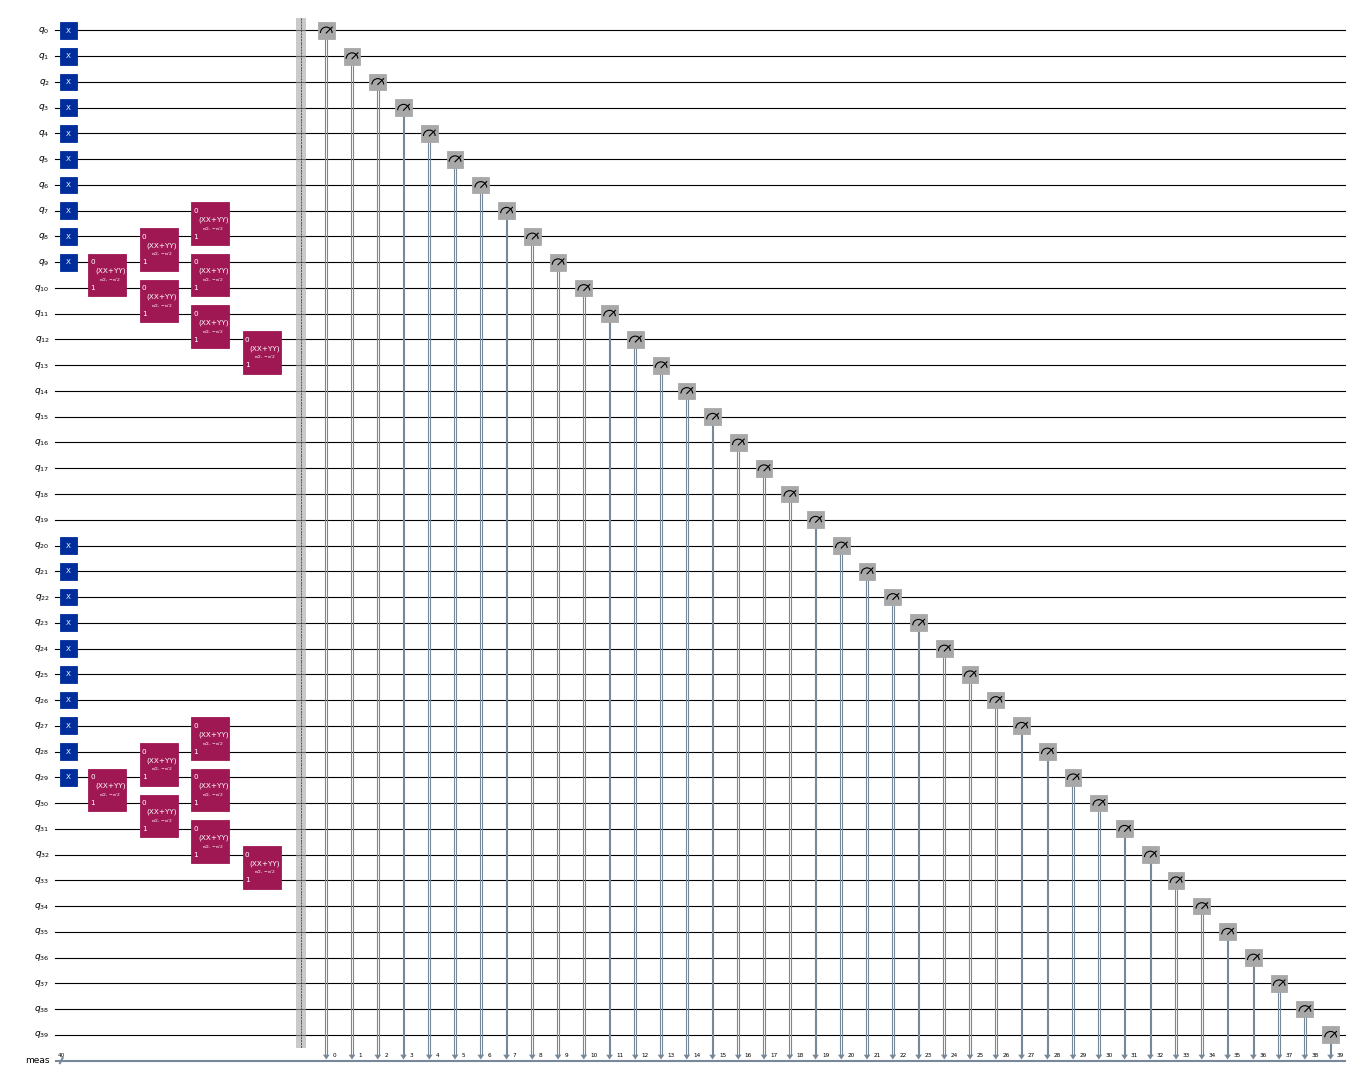

In [3]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

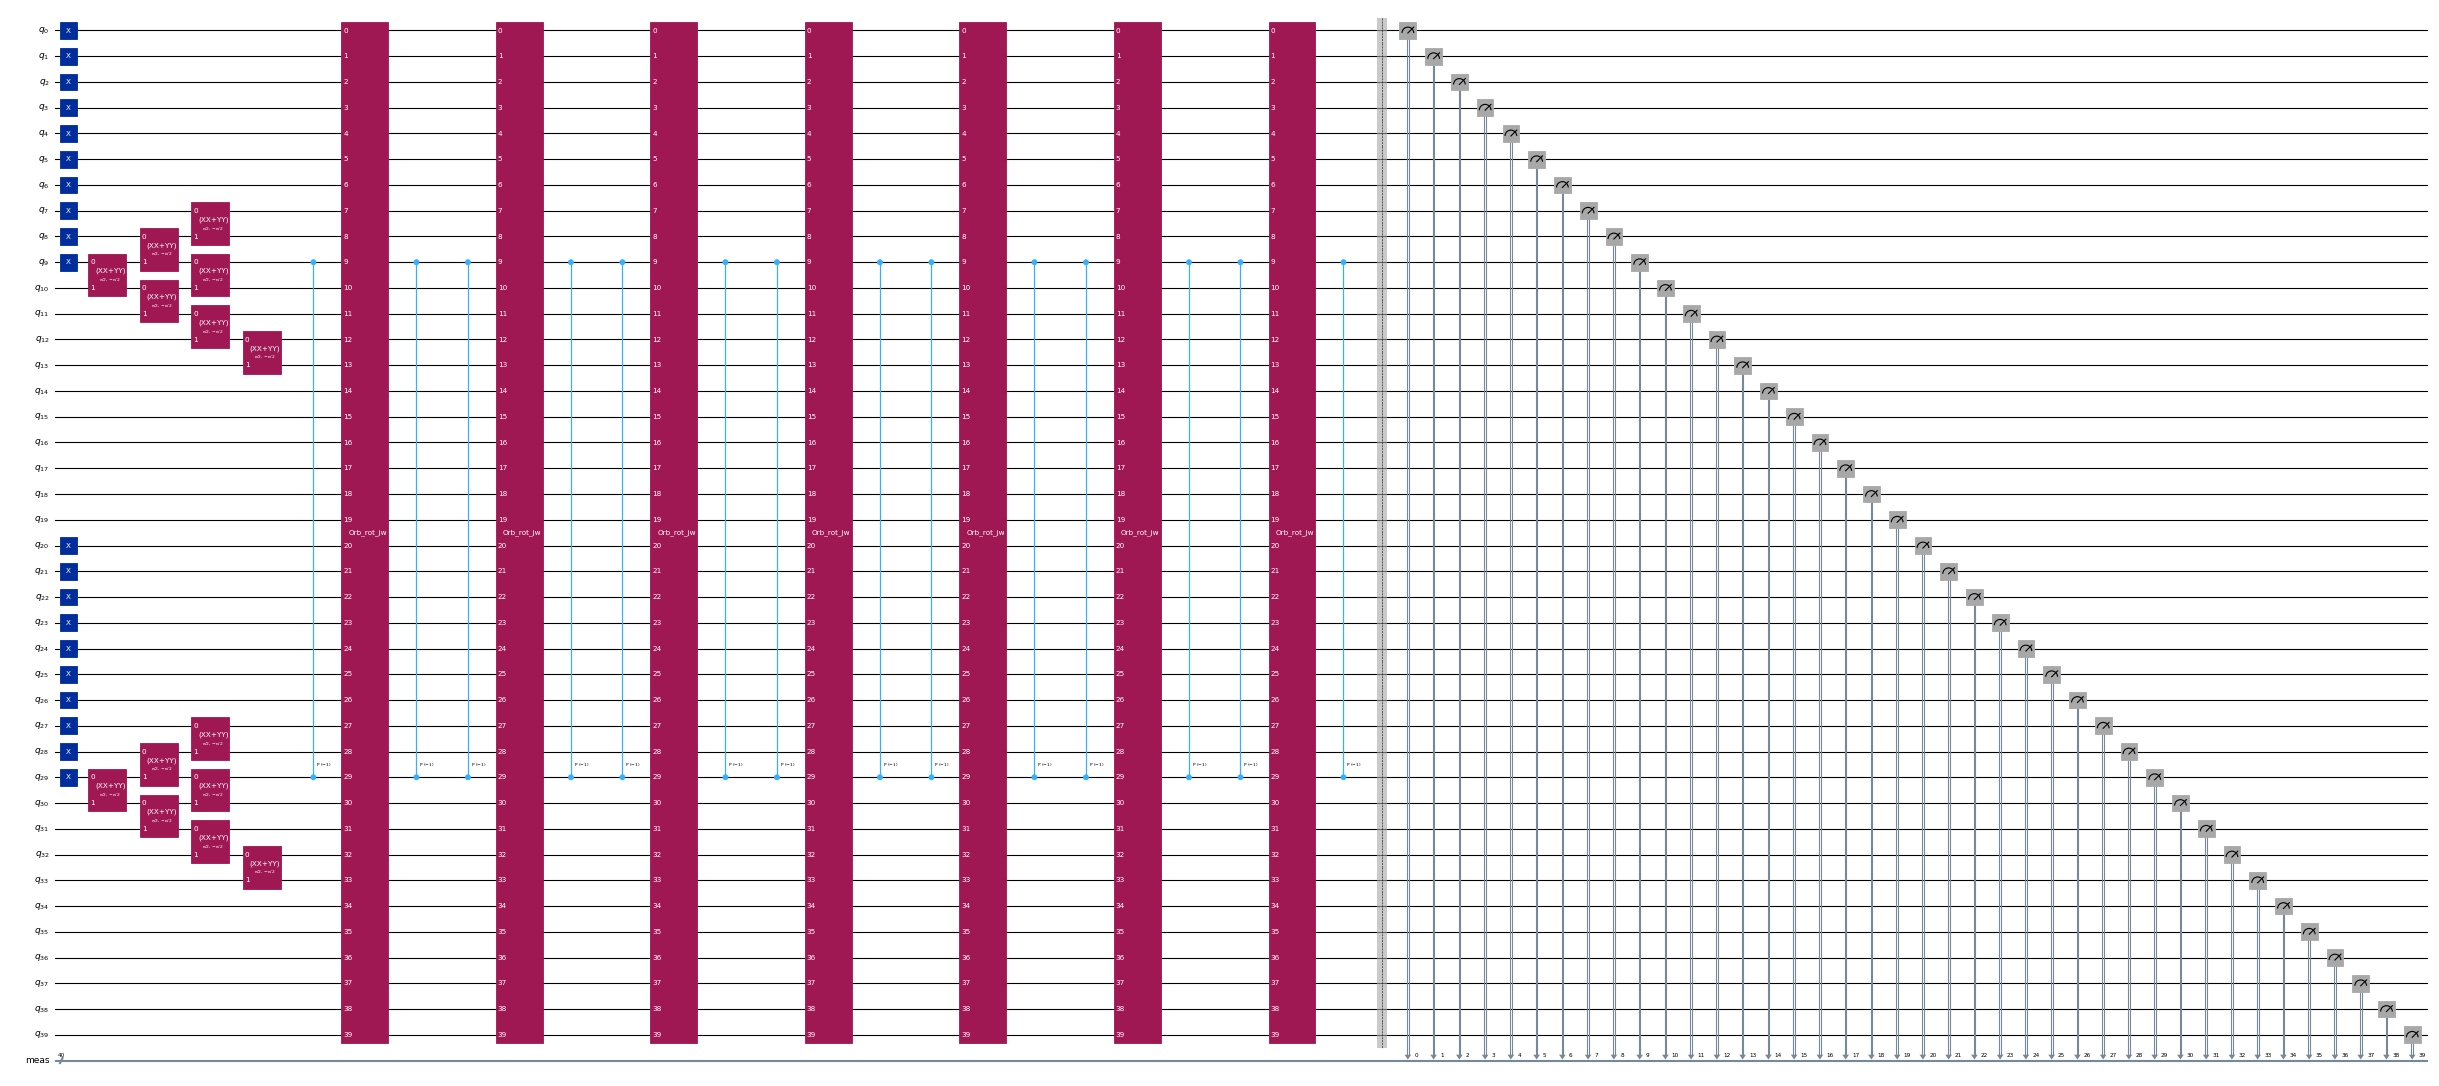

In [4]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

## Step 2: Optimize problem for quantum execution

Now that we have created the circuits, we can optimize them for a target hardware. We pick the least busy QPU with at least 127 qubits. Check out the [Qiskit IBM Runtime docs](https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-sampler) for more info.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(f"Using backend {backend.name}")

Using backend ibm_fez


Now, we transpile the circuits to the target backend using Qiskit.

In [6]:
from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)
isa_circuits = pass_manager.run(circuits)

## Step 3: Execute using Qiskit Primitives

After optimizing the circuits for hardware execution, we are ready to run them on the target hardware and collect samples for ground state energy estimation. After using the Sampler primitive to sample bitstrings from each circuit, we combine all of the results into a single counts dictionary and plot the top 20 most commonly sampled bitstrings.

In [7]:

from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Sample from the circuits
sampler = Sampler(backend)
job = sampler.run(isa_circuits, shots=500)

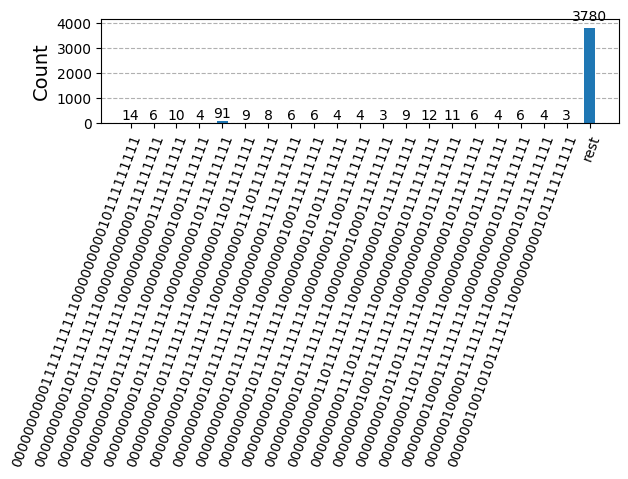

In [8]:
from qiskit.primitives import BitArray

# Combine the counts from the individual Trotter circuits
bit_array = BitArray.concatenate_shots(
    [result.data.meas for result in job.result()]
)

plot_histogram(bit_array.get_counts(), number_to_keep=20)

## Step 4: Post-process and return result to desired classical format

Now, we run the SQD algorithm using the `diagonalize_fermionic_hamiltonian` function. See the [API documentation](https://qiskit.github.io/qiskit-addon-sqd/apidocs/qiskit_addon_sqd.fermion.html#qiskit_addon_sqd.fermion.diagonalize_fermionic_hamiltonian) for explanations of the arguments to this function.

In [9]:
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )


rng = np.random.default_rng(24)
result = diagonalize_fermionic_hamiltonian(
    h1e_momentum,
    h2e_momentum,
    bit_array,
    samples_per_batch=100,
    norb=norb,
    nelec=nelec,
    num_batches=3,
    max_iterations=5,
    symmetrize_spin=True,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -28.613950404637475
		Subspace dimension: 10609
	Subsample 1
		Energy: -28.644264002143814
		Subspace dimension: 13689
	Subsample 2
		Energy: -28.644402666542508
		Subspace dimension: 11236
Iteration 2
	Subsample 0
		Energy: -28.646693893433937
		Subspace dimension: 35344
	Subsample 1
		Energy: -28.662537870100625
		Subspace dimension: 39601
	Subsample 2
		Energy: -28.67107515338331
		Subspace dimension: 37636
Iteration 3
	Subsample 0
		Energy: -28.671897948985627
		Subspace dimension: 42025
	Subsample 1
		Energy: -28.68220919975066
		Subspace dimension: 43681
	Subsample 2
		Energy: -28.67729724087943
		Subspace dimension: 42436
Iteration 4
	Subsample 0
		Energy: -28.698997458723717
		Subspace dimension: 49284
	Subsample 1
		Energy: -28.69893712755414
		Subspace dimension: 48841
	Subsample 2
		Energy: -28.68676139867181
		Subspace dimension: 49729
Iteration 5
	Subsample 0
		Energy: -28.699215759146202
		Subspace dimension: 54289
	Subsample 1
		Energy:

The following code cell plots the results. The first plot shows the computed energy as a function of the number of configuration recovery iterations, and the second plot shows the average occupancy of each spatial orbital after the final iteration. For the reference energy, we use the results of a [DMRG](https://en.wikipedia.org/wiki/Density_matrix_renormalization_group) calculation that was performed separately.

Reference (DMRG) energy: -28.70660
SQD energy: -28.69933
Absolute error: 0.00727


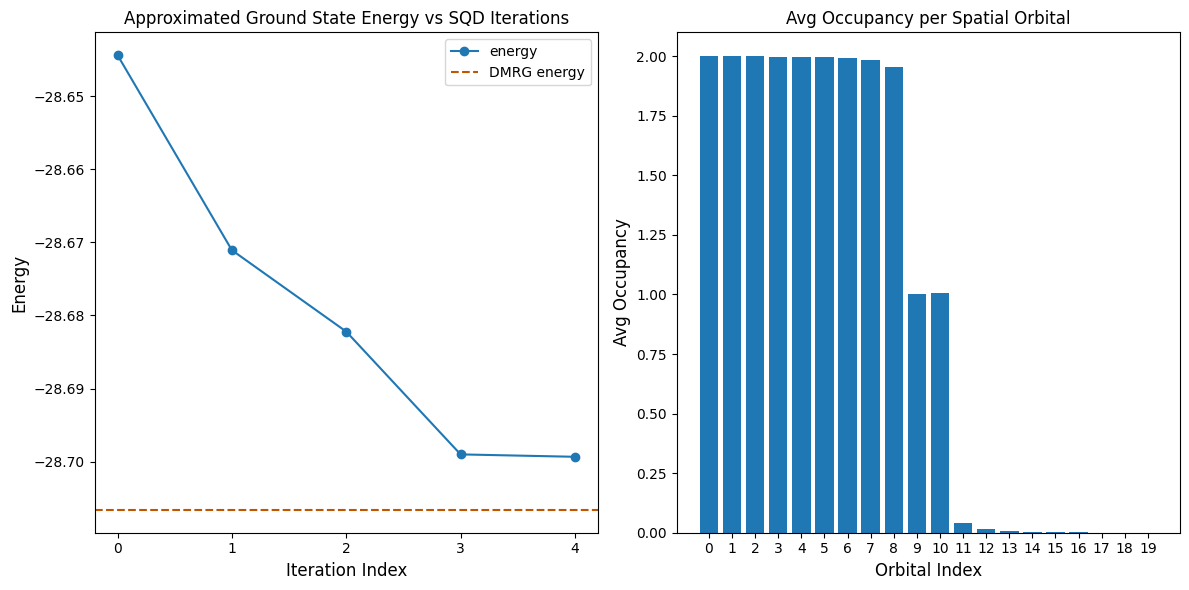

In [10]:
import matplotlib.pyplot as plt

dmrg_energy = -28.70659686

min_es = [
    min(result, key=lambda res: res.energy).energy
    for result in result_history
]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])

# Data for energies plot
x1 = range(len(result_history))

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, min_es, label="energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].axhline(
    y=dmrg_energy, color="#BF5700", linestyle="--", label="DMRG energy"
)
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Reference (DMRG) energy: {dmrg_energy:.5f}")
print(f"SQD energy: {min_e:.5f}")
print(f"Absolute error: {abs(min_e - dmrg_energy):.5f}")
plt.tight_layout()
plt.show()